In [1]:
import pandas as pd
import numpy as np
import nfl_data_py as nfl
import os
import urllib.request
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.lines import Line2D
import scipy as sp
from scipy.spatial import ConvexHull
import utils as NFLUtils

In [8]:
eval_frame_df = pd.read_csv('./data/eval_frame_df.csv')
eval_tracking_df = pd.read_csv('./data/eval_tracking_df.csv')
tackles_df = pd.read_csv('./data/tackles.csv')

eval_tracking_df['displayId'] = eval_tracking_df['displayName'] + eval_tracking_df['nflId'].map(str)

In [2]:
def in_box(players, bounding_box):
    """ 
    Check if a point is in a box (works in conjunction with calculate_voronoi_areas)
    Params: 
    - players (np.array()): a 2D array of the coordinates of all the players
    - bounding_box (tuple): the coordinates of the bounds in the form (x_min, x_max, y_min, y_max)
    """
    return np.logical_and(np.logical_and(bounding_box[0] <= players[:, 0],
                                         players[:, 0] <= bounding_box[1]),
                          np.logical_and(bounding_box[2] <= players[:, 1],
                                         players[:, 1] <= bounding_box[3]))

In [12]:
def plot_weighted_voronoi_areas_without_defender(df, defender, x_min:float=10, x_max=110, y_min=0, y_max=53.3, tpc_dict:dict=None): 
    """
    Custom Voronoi utils. TLDR: mirror the points over x_min, x_max, y_min, y_max to create a boundaries. Use shoelace method to calculate area of each region. Some become negative because of quirks w the floating point numbers
    
    df (pd.DataFrame): the data frame of frame_data from the organize_game_data method. Has columsn: [nflId, time, playDirection, x, y, s, a, dis, o, dir, event, is_offense, ballCarrierId]
    x_min (float): the minimum x value at which we end analysis
    x_max (float): max x value in the analysis, default 110 because that's the endzone
    y_min (float), y_max(float): bounds for y
    plot_graph (bool): whether you want to generate a plot or not
    tpc_dict (dict): a dictionary indexed by nflId with the TPC for that frame of every player. Used in the plot_graph if specified. 
    ax: if calling from another method, pass the axis
    """

    _, ax = plt.subplots(figsize=(23, 16))

    def_color, off_color, ball_carrier_color = '#F86161', '#FFC482', '#FFC482'

    df['is_offense'] = df['club'] == df['possessionTeam']
    df = df[df.club!='football']

    # get the voronoi vertices before blocker is removed
    df['vertices'] = NFLUtils.calculate_voronoi_areas(df).vertices
    df['vertices_before'] = NFLUtils.calculate_voronoi_areas(df).vertices
    blockers = NFLUtils.find_clear_path(df)
    df['is_blocker'] = df['nflId'].isin(blockers)

    # get the voronoi vertices after blocker is removed
    df['vertices'] = NFLUtils.calculate_voronoi_areas(df[df.nflId != defender]).vertices
    df['vertices_after'] = NFLUtils.calculate_voronoi_areas(df[df.nflId != defender]).vertices
    blockers = NFLUtils.find_clear_path(df[df.nflId!=defender])
    df['is_blocker_after'] = df['nflId'].isin(blockers)
    df = df[df.nflId!=defender]
    pd.reset_option("mode.chained_assignment")

    ball_carrier = df[df['nflId'] == df['ballCarrierId']].iloc[0]

    max_x, max_y = 120, 160/3
    endzone_length = 10
    x, y, dir, speed = x, y, dir, speed = ball_carrier['x'], ball_carrier['y'], ball_carrier['dir'], ball_carrier['s']

    # Calculate the velocity vector components
    velocity_x = speed * np.cos(np.radians(dir))
    velocity_y = speed * np.sin(np.radians(dir))

    def angle_from_vector(x_0, y_0, velocity_x, velocity_y, x, y):
        vector_to_point = np.array([x - x_0, y - y_0])
        velocity_vector = np.array([velocity_x, velocity_y])
        magnitude_vector_to_point = np.linalg.norm(vector_to_point)
        magnitude_velocity_vector = np.linalg.norm(velocity_vector)
        dot_product = np.dot(velocity_vector, vector_to_point)
        cosine_theta = dot_product / (magnitude_velocity_vector * magnitude_vector_to_point)
        theta_radians = np.arccos(cosine_theta)
        theta_degrees = np.degrees(theta_radians)
        return theta_degrees

    def weight_space(x_0,y_0, velocity_x, velocity_y, x, y):
        angle_from_velocity = angle_from_vector(x_0, y_0, velocity_x, velocity_y, x, y)
        angle_from_endzone = angle_from_vector(x_0, y_0, max_x - endzone_length - x_0, (max_y / 2) - y_0, x, y)
        distance = np.sqrt((x - x_0)**2 + (y - y_0)**2)
        penalty = (angle_from_velocity + angle_from_endzone) / (360 * 4)
        weight = 1 / (0.5 + distance**0.5) - penalty
        return weight

    x_range = np.linspace(0, int(max_x), int(max_x))
    y_range = np.linspace(0, int(max_y), int(max_x))

    # Initialize an array to store weight_space values
    Z = np.zeros((len(x_range), len(y_range)))

    # Calculate the weight_space values for each point in the grid
    for i, x_val in enumerate(x_range):
        for j, y_val in enumerate(y_range):
            Z[i, j] = weight_space(x, y, velocity_x, velocity_y, x_val, y_val)

    # Rescale the matrix to be between 0 and 1 (min-max scaling)
    min_value = np.min(Z)
    max_value = np.max(Z)
    Z_scaled = (Z - min_value) / (max_value - min_value)

    # Plot the filled contour using the colormap
    colors = ["white", "#008AFF", "#003CFF"]
    nodes = [0.0, 0.5, 1.0]
    my_cmap = LinearSegmentedColormap.from_list("mycmap", list(zip(nodes, colors)))

    contour_levels = np.linspace(Z_scaled.min(), Z_scaled.max(), 100)
    plt.contourf(x_range, y_range, Z_scaled.T, levels=contour_levels, cmap=my_cmap)

    # filter points to the ones in the relevant region
    df_filtered = df[df['x'].between(x_min, x_max) & df['y'].between(y_min, y_max)].copy() # this seems redundant, but we need the df to be filtered to match each point to an nflId in the future. 
    df_filtered = df_filtered[df_filtered['club'] != 'football']
    players = df_filtered[['x', 'y']].to_numpy()
    bounding_box = (x_min, x_max, y_min, y_max)

    # Select towers inside the bounding box
    i = in_box(players, bounding_box)
    # Mirror points
    points_center = players[i, :]
    points_left = np.copy(points_center)
    points_left[:, 0] = bounding_box[0] - (points_left[:, 0] - bounding_box[0])
    points_right = np.copy(points_center)
    points_right[:, 0] = bounding_box[1] + (bounding_box[1] - points_right[:, 0])
    points_down = np.copy(points_center)
    points_down[:, 1] = bounding_box[2] - (points_down[:, 1] - bounding_box[2])
    points_up = np.copy(points_center)
    points_up[:, 1] = bounding_box[3] + (bounding_box[3] - points_up[:, 1])
    points = np.append(points_center,
                       np.append(np.append(points_left,
                                           points_right,
                                           axis=0),
                                 np.append(points_down,
                                           points_up,
                                           axis=0),
                                 axis=0),
                       axis=0)

    # Compute Voronoi
    vor = sp.spatial.Voronoi(points)

    # only pay attention to the points related to players in the relevant region
    vor.filtered_points = points_center
    vor.filtered_regions = [vor.regions[vor.point_region[i]] for i in range(len(points_center))]
    vertices = [vor.vertices[vor.filtered_regions[idx], :] for idx in range(len(vor.filtered_regions))]
    areas = [ConvexHull(vor.vertices[vor.filtered_regions[idx], :]).volume for idx in range(len(vor.filtered_regions))]  # pull the areas and zip them indexed to the vertices passed in
    df_filtered['voronoi_area'] = areas
    df_filtered['vertices'] = vertices

    # Plot Voronoi diagram
    for i, region in enumerate(vor.filtered_regions):
        polygon = [vor.vertices[i] for i in region]
        ax.fill(*zip(*polygon), fill=False, color='white', edgecolor='white', linewidth=2, alpha=0.4)

    # Plotting velocity vectors
    for _, row in df.iterrows():
        if row['club'] == 'football':
            continue
        color = def_color if not row['is_offense'] else off_color if not row['nflId'] != row['ballCarrierId'] else ball_carrier_color
        alpha = 0.3 if row['is_offense'] and row['nflId'] != row['ballCarrierId'] and not row['is_blocker'] else 0.8
        velocity_x = speed * np.cos(np.radians(row['dir']))
        velocity_y = speed * np.sin(np.radians(row['dir']))
        ax.quiver(row['x'], row['y'], velocity_x / 6, velocity_y / 6, angles='xy', scale_units='xy', scale=1, width=0.02, headwidth=1, color=color, label='Velocity', alpha=alpha)
        # plt.quiver(row['x'], row['y'], velocity_x * 5, velocity_y * 5, angles='xy', scale_units='xy', scale=1, width=0.004, headwidth=1, color=color, label='Velocity', alpha=alpha)

    # Shadow for ball carrier
    ax.scatter(x, y, s=2500, c='#1AFF31', alpha=0.75, marker='o', label='Ball Carrier')
    # plt.scatter(x, y, s=400, c='#1AFF31', alpha=0.85, marker='o', label='Ball Carrier')

    # Plotting player dots
    for _, row in df.iterrows():
        if row['club'] == 'football':
            continue
        color = def_color if not row['is_offense'] else off_color if not row['nflId'] != row['ballCarrierId'] else ball_carrier_color
        alpha = 0.4 if row['is_offense'] and row['nflId'] != row['ballCarrierId'] and not row['is_blocker'] else 1
        ax.scatter(row['x'], row['y'], s=1000, c=color, alpha=alpha, marker='o', label='Ball Carrier')
        # plt.scatter(row['x'], row['y'], s=300, c=color, alpha=alpha, marker='o', label='Ball Carrier')

    # plotting the lines bounded by the ball carrier
    for index, row in df.iterrows():
        if row['nflId'] == row['ballCarrierId'] or row['is_blocker']:
            vertices = np.array(row['vertices_before'])
            x_coordinates, y_coordinates = zip(*vertices)
            ax.plot(vertices[:, 0], vertices[:, 1], color='white', linewidth=2)
            ax.fill(x_coordinates, y_coordinates, fill=True, edgecolor='white', linewidth=2, color=(0.4, 0.0, 0.4, 0.4), alpha=.5)  # Dark purple with transparency
            # plt.plot(vertices[:, 0], vertices[:, 1], color='black')
        if row['nflId'] == row['ballCarrierId'] or row['is_blocker_after']:
            vertices = np.array(row['vertices_after'])
            x_coordinates, y_coordinates = zip(*vertices)
            ax.plot(vertices[:, 0], vertices[:, 1], color='white', linewidth=2)
            ax.fill(x_coordinates, y_coordinates, fill=True, edgecolor='white', linewidth=2, color=(0.75, 0.58, 0.89, 0.5), alpha=.5)  # Light purple with transparency

            # Set the x and y limits
    ax.set_xlim(0, 120)
    ax.set_ylim(0, 160/3)

    ax.set_axis_off()


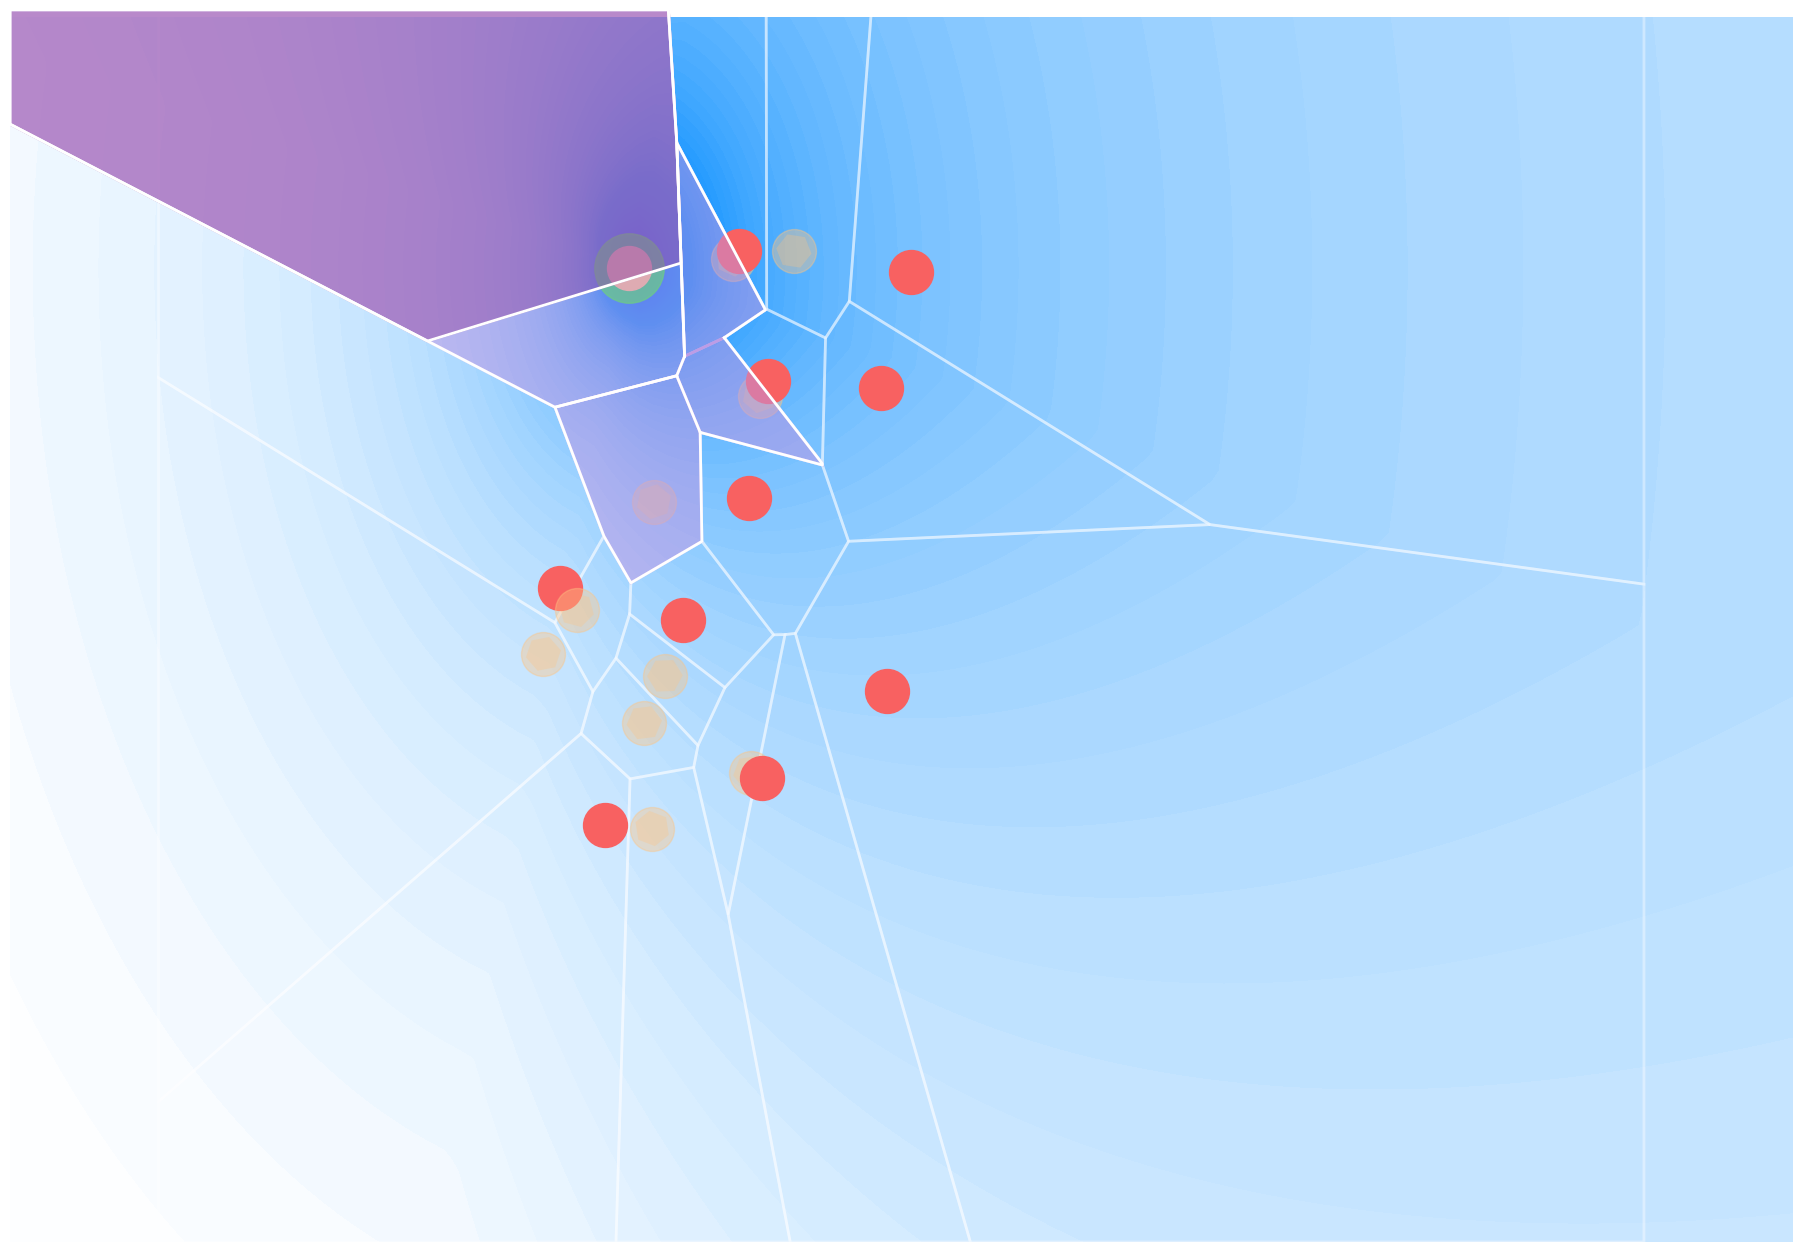

In [13]:
pd.set_option('mode.chained_assignment', None)

# temp_df = eval_tracking_df[(eval_tracking_df['gameId'] == 2022110600) & (eval_tracking_df['playId'] == 1082) & (eval_tracking_df['frameId'] == 31)] #29 30
temp_df = eval_tracking_df[(eval_tracking_df['gameId'] == 2022092502) & (eval_tracking_df['playId'] == 3510) & (eval_tracking_df['frameId'] == 10)] #10 11
# temp_df = eval_tracking_df[(eval_tracking_df['gameId'] == 2022110700) & (eval_tracking_df['playId'] == 1171) & (eval_tracking_df['frameId'] == 33)] #32 33

# temp_df = eval_tracking_df[(eval_tracking_df['gameId'] == 2022092504) & (eval_tracking_df['playId'] == 554) & (eval_tracking_df['frameId'] == 24)] #29 30

# temp_df = eval_tracking_df[(eval_tracking_df['gameId'] == 2022100205) & (eval_tracking_df['playId'] == 3163) & (eval_tracking_df['frameId'] == 13)] # 

# temp_df['is_offense'] = temp_df['club'] == temp_df['possessionTeam']
# blockers = {42794, 53526}
# temp_df['is_blocker'] = temp_df['nflId'].isin(blockers)
plot_weighted_voronoi_areas_without_defender(temp_df, 42406.0, 10, 110, 0, 53.3)

pd.reset_option("mode.chained_assignment")
